#Train

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from torch.cuda.amp import GradScaler, autocast
import pandas as pd
import json

In [ ]:
!gdown --folder https://drive.google.com/drive/folders/1CAbb3DjrOPBNm0ozVBfhvrEh9P9rAppc

Retrieving folder contents
Processing file 1e_G-9a66AryHxBOwGWhriePYCCa4_29e subtaskA_dev_monolingual.jsonl
Processing file 123UQ92LxtHaVTbNYlmjnG1CWwD-x7wDL subtaskA_dev_multilingual.jsonl
Processing file 1HeCgnLuDoUHhP-2OsTSSC3FXRLVoI6OG subtaskA_train_monolingual.jsonl
Processing file 13-9-DakCeLFbPgCiVIU0v6_BCQx0ppz6 subtaskA_train_multilingual.jsonl
Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=1e_G-9a66AryHxBOwGWhriePYCCa4_29e
To: /content/SubtaskA/subtaskA_dev_monolingual.jsonl
100% 10.8M/10.8M [00:00<00:00, 49.0MB/s]
Downloading...
From: https://drive.google.com/uc?id=123UQ92LxtHaVTbNYlmjnG1CWwD-x7wDL
To: /content/SubtaskA/subtaskA_dev_multilingual.jsonl
100% 21.2M/21.2M [00:00<00:00, 79.2MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1HeCgnLuDoUHhP-2OsTSSC3FXRLVoI6OG
From (redirected): https://drive.google.com/uc?id=1HeCgnLuDoUHhP-2OsTSSC3FXRLVoI

In [ ]:
# Function to load the dataset from a JSONL file
def load_data(file_path):
    data = []
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            data.append(json.loads(line))
    return pd.DataFrame(data)

In [ ]:
# Preprocess and tokenize the data
def preprocess_data(data, tokenizer, max_length=512):
    tokenized = tokenizer(data['text'].tolist(), padding='max_length', max_length=max_length, truncation=True, return_tensors="pt")
    return tokenized

In [ ]:
# Check if GPU is available and set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [ ]:
# Load tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [ ]:
def save_preprocessed_data(tokenized_inputs, labels, file_path='preprocessed_data.pt'):
    torch.save({
        'input_ids': tokenized_inputs['input_ids'],
        'attention_mask': tokenized_inputs['attention_mask'],
        'labels': labels
    }, file_path)

def load_preprocessed_data(file_path='preprocessed_data.pt'):
    data = torch.load(file_path)
    return data

In [ ]:

# Load and prepare data
train_data = load_data('data/subtaskA/subtaskA_train_monolingual.jsonl')
tokenized_inputs = preprocess_data(train_data, tokenizer)
labels = torch.tensor(train_data['label'].tolist()).unsqueeze(1)

# Save the preprocessed data
save_preprocessed_data(tokenized_inputs, labels)

In [ ]:

# Load the preprocessed data
preprocessed_data = load_preprocessed_data()
# Create TensorDataset and DataLoader
#dataset = TensorDataset(tokenized_inputs['input_ids'], tokenized_inputs['attention_mask'], labels)
dataset = TensorDataset(preprocessed_data['input_ids'], preprocessed_data['attention_mask'], preprocessed_data['labels'])
data_loader = DataLoader(dataset, batch_size=16, shuffle=True, num_workers=4)

# Define optimizer and loss
optimizer = AdamW(model.parameters(), lr=5e-5)
scaler = GradScaler()

In [ ]:
# Training loop
def train_model(model, data_loader, optimizer, device, epochs=1):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for batch_idx, batch in enumerate(data_loader):
            input_ids, attention_mask, labels = [b.to(device) for b in batch]

            optimizer.zero_grad()

            with autocast():
                outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
                loss = outputs.loss

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            total_loss += loss.item()

            if batch_idx % 20 == 0:  # Log every 100 batches
                print(f'Epoch: {epoch+1}, Batch: {batch_idx}, Loss: {loss.item()}')

        avg_loss = total_loss / len(data_loader)
        print(f'End of Epoch {epoch+1}, Average Loss: {avg_loss}')


In [ ]:
train_model(model, data_loader, optimizer, device)

# Save the trained model
model.save_pretrained('./my_fine_tuned_bert')
tokenizer.save_pretrained('./my_fine_tuned_bert')

Epoch: 1, Batch: 0, Loss: 0.7237396240234375
Epoch: 1, Batch: 20, Loss: 0.593963623046875
Epoch: 1, Batch: 40, Loss: 0.5186614990234375
Epoch: 1, Batch: 60, Loss: 0.34515380859375
Epoch: 1, Batch: 80, Loss: 0.09571170806884766
Epoch: 1, Batch: 100, Loss: 0.39281463623046875
Epoch: 1, Batch: 120, Loss: 0.42992591857910156
Epoch: 1, Batch: 140, Loss: 0.2562241554260254
Epoch: 1, Batch: 160, Loss: 0.0980074405670166
Epoch: 1, Batch: 180, Loss: 0.3342905044555664
Epoch: 1, Batch: 200, Loss: 0.6742444038391113
Epoch: 1, Batch: 220, Loss: 0.37153661251068115
Epoch: 1, Batch: 240, Loss: 0.19369721412658691
Epoch: 1, Batch: 260, Loss: 0.5417435169219971
Epoch: 1, Batch: 280, Loss: 0.2115495204925537
Epoch: 1, Batch: 300, Loss: 0.11365318298339844
Epoch: 1, Batch: 320, Loss: 0.392169713973999
Epoch: 1, Batch: 340, Loss: 0.17237114906311035
Epoch: 1, Batch: 360, Loss: 0.4928017854690552
Epoch: 1, Batch: 380, Loss: 0.09472620487213135
Epoch: 1, Batch: 400, Loss: 0.49457454681396484
Epoch: 1, Batc

('./my_fine_tuned_bert\\tokenizer_config.json',
 './my_fine_tuned_bert\\special_tokens_map.json',
 './my_fine_tuned_bert\\vocab.txt',
 './my_fine_tuned_bert\\added_tokens.json')

#Test

In [ ]:
# Copy the file from your Google Drive to the current directory.
!cp /content/drive/MyDrive/DeepLearning/Project/BERT/my_fine_tuned_bert.zip .

In [ ]:
# Import the required libraries
import zipfile

# Specify the path to the zip file
zip_file_path = "/content/my_fine_tuned_bert.zip"

# Open the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    # Extract all the files in the zip file to the current directory
    zip_ref.extractall()

In [ ]:
# Load tokenizer and model
tokenizer = BertTokenizer.from_pretrained('/content/my_fine_tuned_bert')
model = BertForSequenceClassification.from_pretrained('/content/my_fine_tuned_bert', num_labels=2)
model.to(device)
model.eval()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

Test with mupltiple token limits

In [ ]:
def preprocess_data(data, tokenizer, max_length=512):
    tokenized = tokenizer(data['text'].tolist(), padding='max_length', max_length=max_length, truncation=True, return_tensors="pt")
    return tokenized


In [ ]:
# Load and prepare data
test_data = load_data('/content/SubtaskA/subtaskA_dev_monolingual.jsonl')

In [ ]:
# Generate predictions
def generate_predictions(model, dataloader):
    predictions = []
    with torch.no_grad():
        for batch in dataloader:
            inputs = {'input_ids': batch[0].to(device),
                      'attention_mask': batch[1].to(device)}
            outputs = model(**inputs)
            logits = outputs.logits
            preds = torch.argmax(logits, dim=1)
            predictions.extend(preds.cpu().numpy())
    return predictions

#predictions = generate_predictions(model, test_loader)

In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def print_evaluation_metrics(predictions, true_labels, limit):
    accuracy = accuracy_score(true_labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predictions, average='binary')
    print(f'Accuracy: {accuracy}')
    print(f'Precision: {precision}')
    print(f'Recall: {recall}')
    print(f'F1 Score: {f1}')

    # Compute confusion matrix
    cm = confusion_matrix(true_labels, predictions)
    print("Confusion Matrix:")
    print(cm)

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Human', 'Machine'], yticklabels=['Human', 'Machine'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    plt.savefig(f"/content/drive/MyDrive/DeepLearning/Project/BERT/confusion_matrix_{limit}.png")


Evaluating model with max token limit: 10
BERT metrics for 10 token limit
Accuracy: 0.593
Precision: 0.5929628148740503
Recall: 0.5932
F1 Score: 0.5930813837232553
Confusion Matrix:
[[1482 1018]
 [1017 1483]]


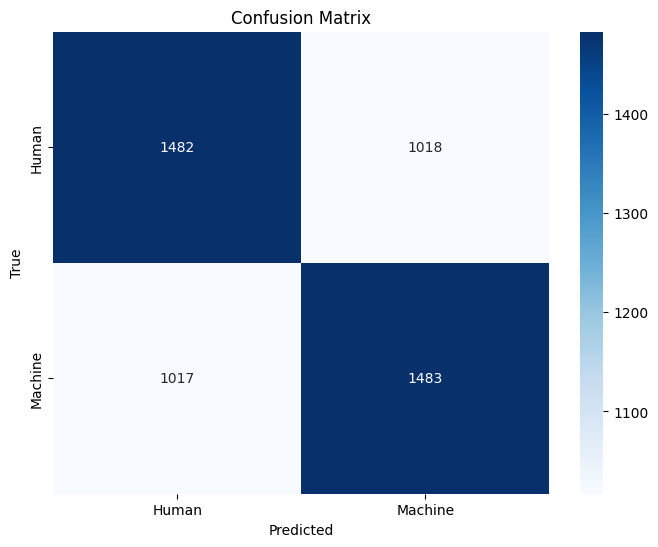

Evaluating model with max token limit: 20
BERT metrics for 20 token limit
Accuracy: 0.5946
Precision: 0.5783371977475985
Recall: 0.6984
F1 Score: 0.632723319441928
Confusion Matrix:
[[1227 1273]
 [ 754 1746]]


<Figure size 640x480 with 0 Axes>

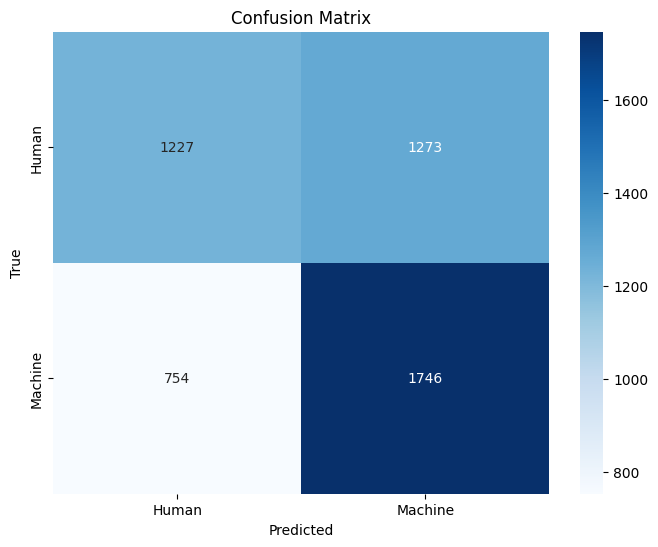

Evaluating model with max token limit: 50
BERT metrics for 50 token limit
Accuracy: 0.6046
Precision: 0.5893406217970618
Recall: 0.69
F1 Score: 0.6357103372028745
Confusion Matrix:
[[1298 1202]
 [ 775 1725]]


<Figure size 640x480 with 0 Axes>

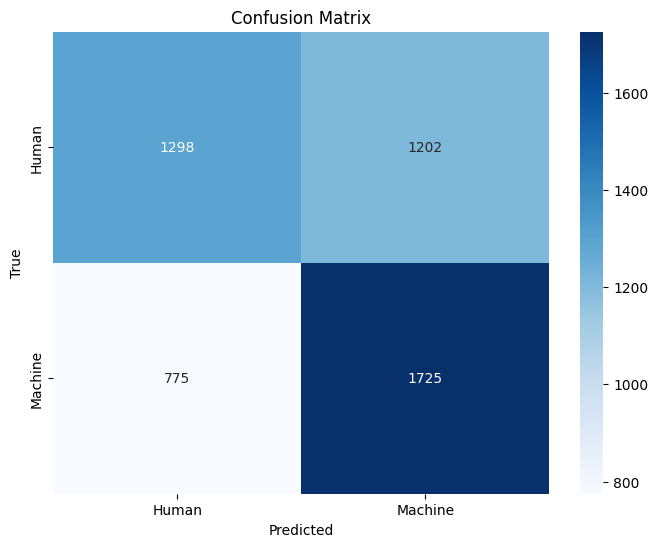

Evaluating model with max token limit: 100
BERT metrics for 100 token limit
Accuracy: 0.6214
Precision: 0.6112128984976182
Recall: 0.6672
F1 Score: 0.6379804934021801
Confusion Matrix:
[[1439 1061]
 [ 832 1668]]


<Figure size 640x480 with 0 Axes>

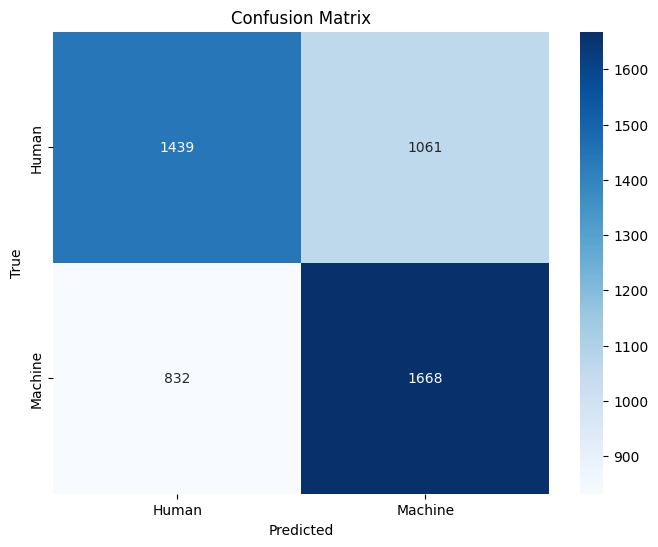

Evaluating model with max token limit: 200
BERT metrics for 200 token limit
Accuracy: 0.6578
Precision: 0.7161643835616438
Recall: 0.5228
F1 Score: 0.604393063583815
Confusion Matrix:
[[1982  518]
 [1193 1307]]


<Figure size 640x480 with 0 Axes>

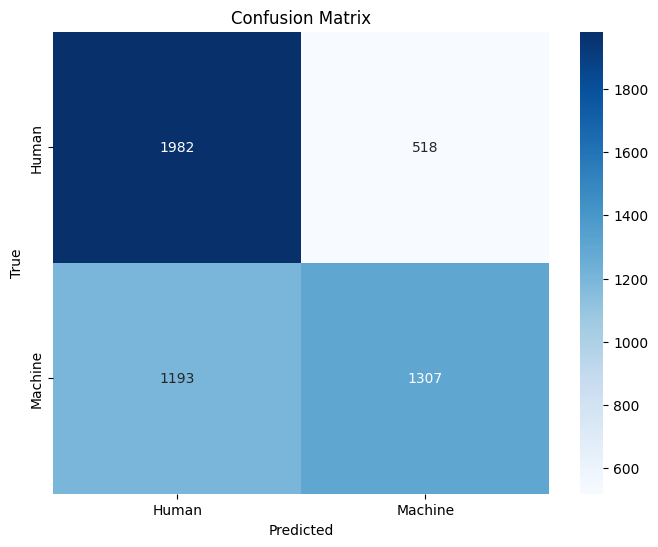

Evaluating model with max token limit: 500
BERT metrics for 500 token limit
Accuracy: 0.704
Precision: 0.8728070175438597
Recall: 0.4776
F1 Score: 0.6173733195449845
Confusion Matrix:
[[2326  174]
 [1306 1194]]


<Figure size 640x480 with 0 Axes>

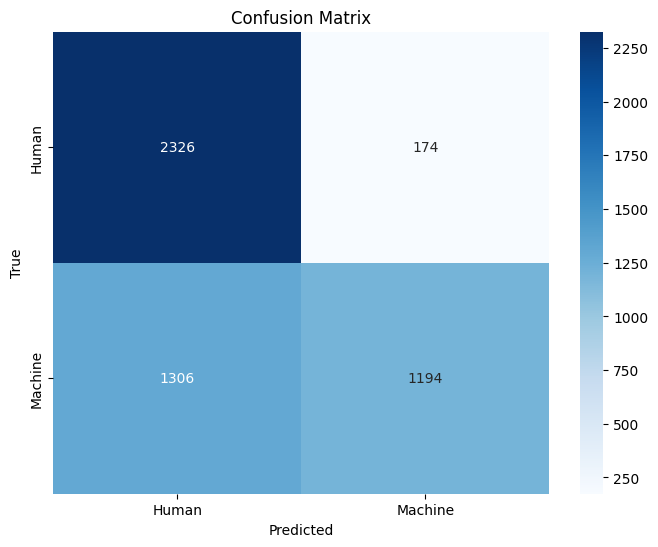

<Figure size 640x480 with 0 Axes>

In [ ]:
token_limits = [10, 20, 50, 100, 200, 500]

for limit in token_limits:
    print(f"Evaluating model with max token limit: {limit}")

    # Preprocess test data with current token limit
    tokenized_test = preprocess_data(test_data, tokenizer, max_length=limit)

    # Extract labels
    test_labels = torch.tensor(test_data['label'].tolist()).unsqueeze(1)

    # Create TensorDataset and DataLoader
    test_dataset = TensorDataset(tokenized_test['input_ids'], tokenized_test['attention_mask'])
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    # Generate predictions
    predictions = generate_predictions(model, test_loader)

    print(f"BERT metrics for {limit} token limit")
    # Assuming you have a function to evaluate predictions:
    print_evaluation_metrics(predictions, test_labels, limit)


In [ ]:
def save_preprocessed_data_test(tokenized_inputs, file_path='preprocessed_data.pt'):
    torch.save({
        'input_ids': tokenized_inputs['input_ids'],
        'attention_mask': tokenized_inputs['attention_mask']
    }, file_path)

In [ ]:
# Load and prepare data
test_data = load_data('/content/SubtaskA/subtaskA_dev_monolingual.jsonl')
tokenized_test = preprocess_data(test_data, tokenizer)
#labels = torch.tensor(test_data['label'].tolist()).unsqueeze(1)

# Save the preprocessed data
save_preprocessed_data_test(tokenized_test, 'preprocessed_test_data.pt')

In [ ]:
# Create TensorDataset and DataLoader
preprocessed_data = load_preprocessed_data('preprocessed_test_data.pt')
test_dataset = TensorDataset(preprocessed_data['input_ids'], preprocessed_data['attention_mask'])
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [ ]:
# Save predictions to JSONL for scoring
def save_predictions(predictions, data, file_path):
    with open(file_path, 'w') as f:
        for idx, pred in enumerate(predictions):
            result = {
                "id": str(data.iloc[idx]['id']),  # Convert ID to string if needed
                "label": int(pred)  # Ensure label is a Python int
            }
            f.write(json.dumps(result) + "\n")

save_predictions(predictions, test_data, 'BERT_SubtaskA_mono_results.jsonl')

Evaluating by source

In [ ]:
import pandas as pd
from torch.utils.data import DataLoader, TensorDataset
from transformers import BertTokenizer, BertForSequenceClassification

# Assuming tokenizer and model are already loaded and set to evaluation mode
tokenizer = BertTokenizer.from_pretrained('/content/my_fine_tuned_bert')
model = BertForSequenceClassification.from_pretrained('/content/my_fine_tuned_bert')
model.eval()
model.to(device)

# Load the dataset
def load_data_by_source(file_path):
    data = pd.read_json(file_path, lines=True)
    return data

# Prepare and tokenize data for each source
def prepare_data_by_source(data, tokenizer):
    sources = data['source'].unique()
    data_loaders = {}
    for source in sources:
        source_data = data[data['source'] == source]
        tokenized = tokenizer(source_data['text'].tolist(), padding='max_length', max_length=512, truncation=True, return_tensors="pt")
        labels = torch.tensor(source_data['label'].tolist()).unsqueeze(1)
        dataset = TensorDataset(tokenized['input_ids'], tokenized['attention_mask'], labels)
        data_loader = DataLoader(dataset, batch_size=16, shuffle=False)
        data_loaders[source] = data_loader
    return data_loaders

dev_data = load_data_by_source('/content/SubtaskA/subtaskA_dev_monolingual.jsonl')
dev_loaders = prepare_data_by_source(dev_data, tokenizer)


Evaluating source: wikihow
Accuracy: 0.688
Precision: 0.9845360824742269
Recall: 0.382
F1 Score: 0.5504322766570605


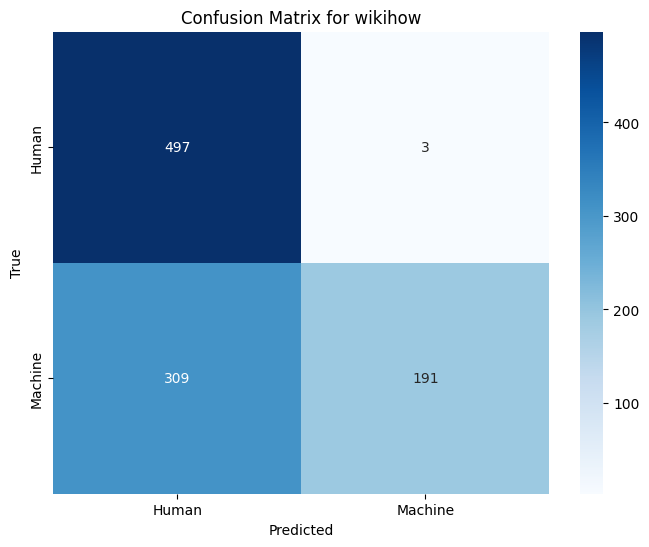

Evaluating source: wikipedia
Accuracy: 0.944
Precision: 0.9683544303797469
Recall: 0.918
F1 Score: 0.942505133470226


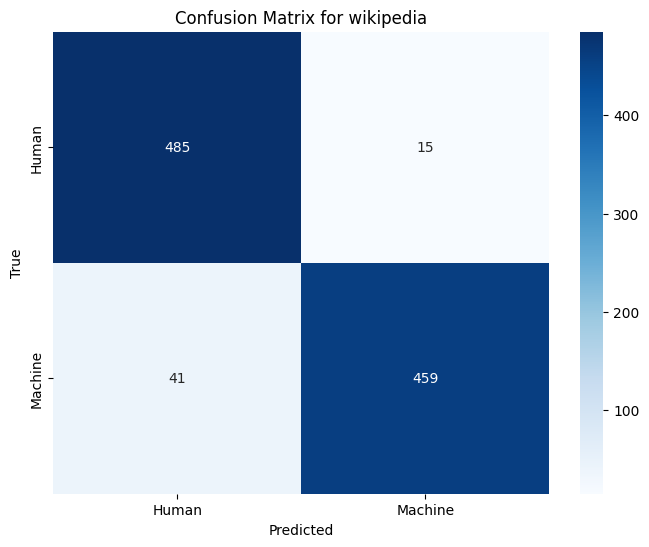

Evaluating source: reddit
Accuracy: 0.614
Precision: 0.875
Recall: 0.266
F1 Score: 0.4079754601226994


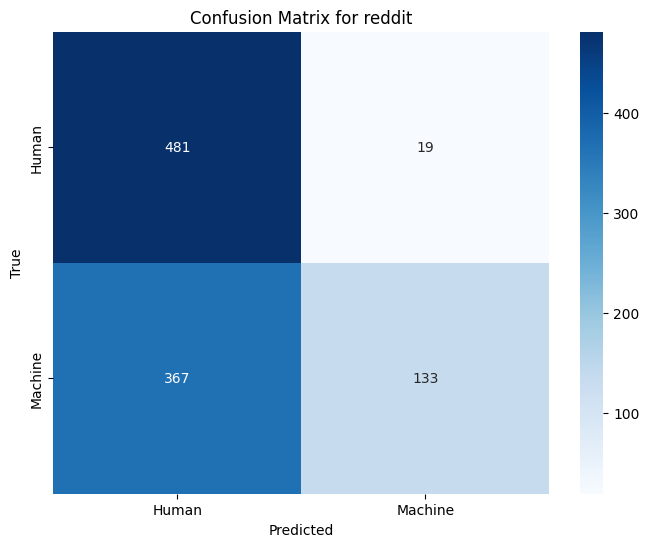

Evaluating source: arxiv
Accuracy: 0.766
Precision: 0.796875
Recall: 0.714
F1 Score: 0.7531645569620253


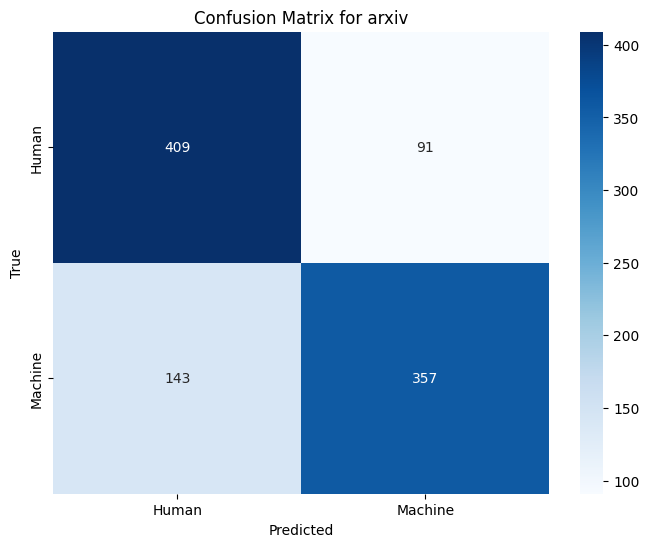

Evaluating source: peerread
Accuracy: 0.522
Precision: 0.6309523809523809
Recall: 0.106
F1 Score: 0.1815068493150685


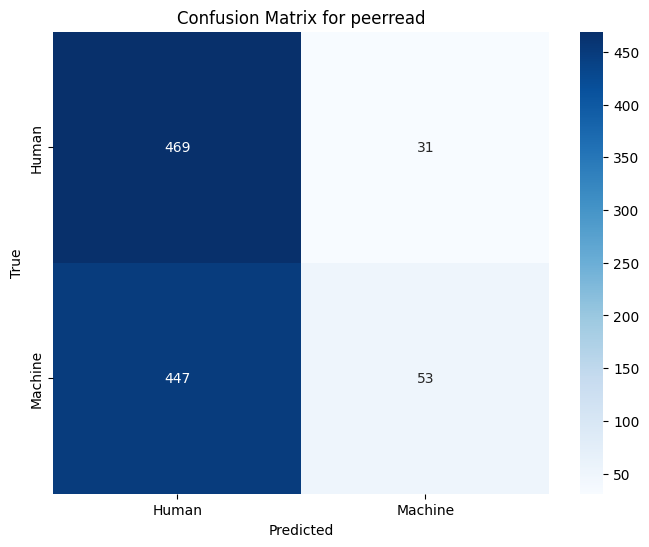

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, precision_recall_fscore_support


def generate_predictions(model, dataloader):
    predictions = []
    with torch.no_grad():
        for batch in dataloader:
            inputs = {'input_ids': batch[0].to(device), 'attention_mask': batch[1].to(device), 'labels': batch[2].to(device)}
            outputs = model(**inputs)
            logits = outputs.logits
            preds = torch.argmax(logits, dim=1)
            predictions.extend(preds.cpu().numpy())
    return predictions

def print_evaluation_metrics(predictions, true_labels):
    accuracy = accuracy_score(true_labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predictions, average='binary')
    print(f'Accuracy: {accuracy}')
    print(f'Precision: {precision}')
    print(f'Recall: {recall}')
    print(f'F1 Score: {f1}')

    # Compute confusion matrix
    cm = confusion_matrix(true_labels, predictions)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Human', 'Machine'], yticklabels=['Human', 'Machine'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix for {source}')
    plt.show()

# Evaluate the model for each source
for source, loader in dev_loaders.items():
    print(f"Evaluating source: {source}")
    true_labels = [label.item() for _, _, label in loader.dataset]
    predictions = generate_predictions(model, loader)
    print_evaluation_metrics(predictions, true_labels)
